 # Bi-LSTM
 Base del código de Geeks for Geeks https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/

## Importar datos y librerías

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Conectamos el drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

path = '/content/drive/MyDrive/Data Tesis/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Load your CSV dataset using pandas
df = pd.read_csv(path + 'updated_sentiment_data.csv')

# Assuming your dataset has 'text' and 'label' columns
texts = df['Content'].values
labels = df['Sentiment'].values

# Split into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Convert the data into a TensorFlow dataset
def make_dataset(texts, labels):
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))
    return dataset

train_dataset = make_dataset(train_texts, train_labels)
test_dataset = make_dataset(test_texts, test_labels)

# Batch and shuffle the training dataset
batch_size = 32
train_dataset = train_dataset.shuffle(10000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [4]:
# Find the maximum length of text in the 'Content' column
mean_length = df['Content'].apply(len).mean()

print("Mean length of text in 'Content' column:", mean_length)

Mean length of text in 'Content' column: 381.2891666666667


In [5]:
example, label = next(iter(train_dataset))
print('Text:\n', example.numpy()[0])
print('\nLabel: ', label.numpy()[0])

Text:
 b"My normie family is trying to force me to get a job right now. I've told them about my antiwork stance before and they said that I was mentally ill and not right in the head. They want me to see a psychiatrist because they think that I'm not okay and have mental illness. Ugh I wish I could just NEET in peace. I don't want to be a normie or do what normies do"

Label:  1


## Modelo

In [6]:
# Using the TextVectorization layer to normalize, split, and map strings
# to integers.
encoder = tf.keras.layers.TextVectorization(
    max_tokens=10000,  # You can adjust this based on your dataset
    output_mode='int',
    output_sequence_length=6700  # Adjust based on your dataset's average text length
)
encoder.adapt(train_dataset.map(lambda text, label: text))

# Extracting the vocabulary from the TextVectorization layer.
vocabulary = np.array(encoder.get_vocabulary())

# Encoding a test example and decoding it back.
original_text = example.numpy()[0]
encoded_text = encoder(original_text).numpy()
decoded_text = ' '.join(vocabulary[encoded_text])

print('original: ', original_text)
print('encoded: ', encoded_text)
print('decoded: ', decoded_text)

original:  b"My normie family is trying to force me to get a job right now. I've told them about my antiwork stance before and they said that I was mentally ill and not right in the head. They want me to see a psychiatrist because they think that I'm not okay and have mental illness. Ugh I wish I could just NEET in peace. I don't want to be a normie or do what normies do"
encoded:  [  10 1340  149 ...    0    0    0]
decoded:  my normie family is trying to force me to get a job right now ive told them about my antiwork stance before and they said that i was mentally ill and not right in the head they want me to see a psychiatrist because they think that im not okay and have mental illness ugh i wish i could just neet in peace i dont want to be a normie or do what normies do                                                                                                                                                                                                                        

In [9]:
# Define input shape
input_shape = (1,)  # The length of your sequences (output_sequence_length)

# Adjusting the final layer and using softmax for multiclass classification
model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape, dtype=tf.string),
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')  # Using softmax activation for 5 classes
])

# Summary of the model
model.summary()

# Compile the model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # For integer-encoded labels
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 6700)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 6700, 64)            │         428,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 6700, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 540,295 (2.06 MB)

 Trainable params: 540,295 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Training the model and validating it on test set
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=test_dataset,
)

Epoch 1/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1433s 47s/step - accuracy: 0.6910 - loss: 1.6461 - val_accuracy: 0.7667 - val_loss: 0.9119
Epoch 2/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1415s 47s/step - accuracy: 0.7824 - loss: 0.8786 - val_accuracy: 0.7667 - val_loss: 0.7688
Epoch 3/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1397s 47s/step - accuracy: 0.7449 - loss: 0.7656 - val_accuracy: 0.7708 - val_loss: 0.7381
Epoch 4/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1498s 50s/step - accuracy: 0.7854 - loss: 0.5829 - val_accuracy: 0.7708 - val_loss: 0.7245
Epoch 5/5
30/30 ━━━━━━━━━━━━━━━━━━━━ 1408s 47s/step - accuracy: 0.8544 - loss: 0.4094 - val_accuracy: 0.7250 - val_loss: 0.8283


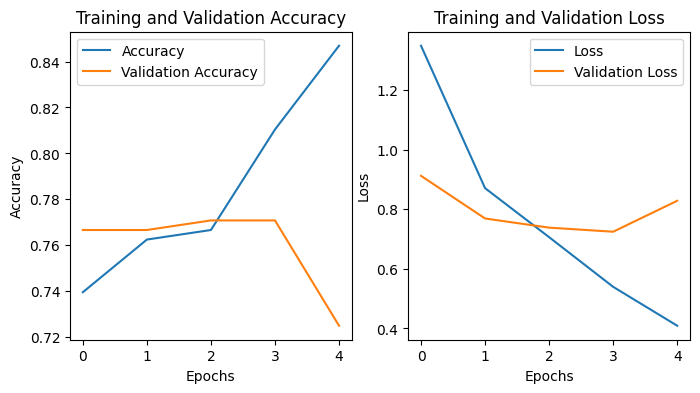

In [11]:
# Training history
history_dict = history.history

# Seperating validation and training accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# Seperating validation and training loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show()

## Model Metrics

In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, f1_score, classification_report

true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

true_labels = np.array(true_labels)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Accuracy: {accuracy:.4f}')

# Calculate recall
recall = recall_score(true_labels, predicted_classes, average='weighted')  # Use 'macro', 'micro', or 'weighted' as needed
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(true_labels, predicted_classes, average='weighted')  # Use 'macro', 'micro', or 'weighted' as needed
print(f'F1 Score: {f1:.4f}')

print("\nClassification Report:\n", classification_report(true_labels, predicted_classes))


8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step
Accuracy: 0.7250
Recall: 0.7250
F1 Score: 0.7009

Classification Report:
               precision    recall  f1-score   support

           1       0.25      0.22      0.24        18
           2       0.00      0.00      0.00         7
           3       0.23      0.16      0.19        31
           5       0.82      0.90      0.86       184

    accuracy                           0.72       240
   macro avg       0.33      0.32      0.32       240
weighted avg       0.68      0.72      0.70       240



## Save model

In [18]:
model.save('my_model.keras')

In [19]:
from google.colab import files

# Download the Keras model file
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>